<a href="https://colab.research.google.com/github/sarangoz/Integraci-n-de-Datos/blob/main/Parcial1ID_SaraArango.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARCIAL 1 - SARA ARANGO

# **Introducción**

El presente ejercicio se centra en el análisis del Heart Attack Risk Prediction Dataset, una base de datos que busca entender los factores que influyen en la probabilidad de sufrir un infarto. **La muestra incluye 8.763 pacientes** de diferentes regiones del mundo, con información tanto clínica como de estilo de vida.

**Dentro de las variables más relevantes se encuentran indicadores médicos como la edad, colesterol, presión arterial, frecuencia cardíaca, diabetes, obesidad, triglicéridos y antecedentes de problemas cardíacos**, así como hábitos relacionados con la salud: tabaquismo, consumo de alcohol, dieta, nivel de ejercicio, horas de sueño y grado de sedentarismo. También se incluyen factores contextuales como ingresos, país, continente y hemisferio de residencia.

El conjunto culmina en una **variable objetivo binaria denominada “Heart Attack Risk”**, que indica si un paciente presenta o no riesgo de sufrir un infarto. A partir de esta información, **el ejercicio busca aplicar técnicas de análisis y modelos predictivos que permitan identificar los principales determinantes del riesgo y aportar insumos útiles para la prevención y gestión de enfermedades cardiovasculares**.

In [91]:
#Paso 1: Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [92]:
#Paso 2: Cargar datos
nxl = "/content/heart_attack_prediction_dataset.csv"
df = pd.read_csv(nxl)

# Revisamos las variables disponibles
print(df.head())
print(df.info())

# Variable objetivo (riesgo de ataque cardiaco)
y = df['Heart Attack Risk']

  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  

In [93]:
#Paso 3: Convertir variables categóricas a numéricas
#Sex y Hemisphere en binario
df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})
df['Hemisphere'] = df['Hemisphere'].map({'Southern Hemisphere': 0, 'Northern Hemisphere': 1})

#One-hot encoding para Diet
df = pd.get_dummies(df, columns=['Diet'], drop_first=False)
df[['Diet_Average', 'Diet_Unhealthy', 'Diet_Healthy']] = df[['Diet_Average', 'Diet_Unhealthy', 'Diet_Healthy']].astype(int)

print("Columnas finales:")
print(df.columns)

Columnas finales:
Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk', 'Diet_Average',
       'Diet_Healthy', 'Diet_Unhealthy'],
      dtype='object')


In [94]:
# Paso 4: Separar Blood Pressure a dos columnas y eliminamos ID
# función para separar sistólica y diastólica
def bp_split(bp):
    sistolica, diastolica = bp.split("/")
    return float(sistolica), float(diastolica)

# aplica la función a toda la columna y expande en dos nuevas columnas
df[['Blood Pressure Systolic', 'Blood Pressure Diastolic']] = df['Blood Pressure'].apply(
    lambda x: pd.Series(bp_split(x))
)

#Eliminamos columna 'Patient ID' y 'Blood Pressure'
df = df.drop('Patient ID', axis=1)
df = df.drop('Blood Pressure', axis=1)

print(df)

      Age  Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0      67    0          208          72         0               0        1   
1      21    0          389          98         1               1        1   
2      21    1          324          72         1               0        0   
3      84    0          383          73         1               1        1   
4      66    0          318          93         1               1        1   
...   ...  ...          ...         ...       ...             ...      ...   
8758   60    0          121          61         1               1        1   
8759   28    1          120          73         1               0        0   
8760   47    0          250         105         0               1        1   
8761   36    0          178          60         1               0        1   
8762   25    1          356          75         1               1        0   

      Obesity  Alcohol Consumption  Exercise Hours Per Week  ..

In [95]:
# Paso 5: Determinar variable de integración
target = 'Heart Attack Risk'

# Calcular correlaciones usando todo el df
correls = df.drop(['Country', 'Continent'], axis=1).corr()[target].sort_values(ascending=False)
print("\nCorrelaciones con la variable objetivo:\n", correls)

# La variable con mayor correlación será la variable de integración
integration_var = correls.index[1]  # ya no está el target en la serie
print(f"\nVariable de integración seleccionada: {integration_var}")
print("\nNota: 'Country' y 'Continent' se excluyen del cálculo de correlaciones.")


Correlaciones con la variable objetivo:
 Heart Attack Risk                  1.000000
Cholesterol                        0.019340
Blood Pressure Systolic            0.018585
Diabetes                           0.017225
Hemisphere                         0.012704
Exercise Hours Per Week            0.011133
Triglycerides                      0.010471
Income                             0.009628
Diet_Healthy                       0.009409
Age                                0.006403
Medication Use                     0.002234
Previous Heart Problems            0.000274
BMI                                0.000020
Diet_Unhealthy                    -0.000803
Family History                    -0.001652
Sex                               -0.003095
Smoking                           -0.004051
Stress Level                      -0.004111
Heart Rate                        -0.004251
Physical Activity Days Per Week   -0.005014
Sedentary Hours Per Day           -0.005613
Blood Pressure Diastolic          

Se identificó que la variable más correlacionada con el riesgo de ataque cardiaco es el **Colesterol**, aunque la correlación de todas las variables es baja, esta variable en especial es la que presenta mayor correlacion por lo que se toma como variable de integración principal para la comparación entre países.

In [96]:
#Paso 6: Funciones de histogramas y caracterización
def Histx(LDA):
    NC = 10
    plt.figure()
    sns.histplot(LDA, kde=True, bins=NC, color='red')
    plt.title('Distribución de la variable de Integracion')
    plt.show()

    counts, bin_edges = np.histogram(LDA, bins=NC)
    LI, LS = bin_edges[:-1], bin_edges[1:]
    mc = (LI + LS)/2
    freq = counts/np.sum(counts)
    return LI, LS, counts, mc, freq

def Caractx(LDA, counts, mc):
    u = np.sum(mc*counts)/np.sum(counts)
    varianza = np.sum(counts*(mc-u)**2)/np.sum(counts)
    desviacion = np.sqrt(varianza)

    # Outliers
    LIe, LSe = u-2*desviacion, u+2*desviacion
    filas_out = np.where((LDA<LIe) | (LDA>LSe))[0]

    cas = np.sum(counts*(mc-u)**3)/(np.sum(counts)*desviacion**3)
    curt = np.sum(counts*(mc-u)**4)/(np.sum(counts)*desviacion**4)-3
    return u, varianza, desviacion, cas, curt, filas_out

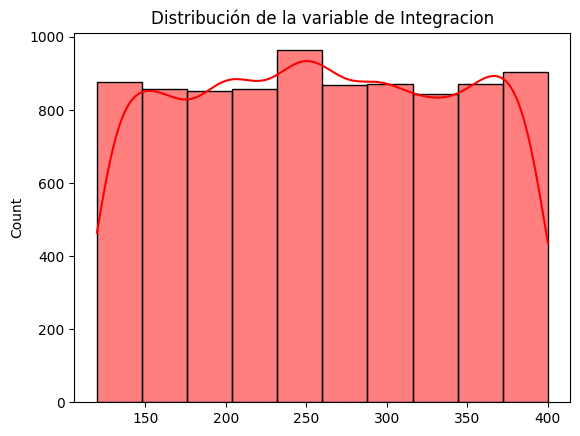


--- Caracterización Variable de Integración (Colesterol)---
Media: 260.39141846399633
Varianza: 6455.858203203069
Desviación: 80.34835532357255
Asimetría: -0.0002829163186290518
Curtosis: -1.2091128493676402
Número de outliers: 0


In [97]:
#Paso 7: Caracterización de la variable de integración
LDA = df[integration_var].values
LI, LS, counts, mc, freq = Histx(LDA)
u, varianza, desviacion, cas, curt, outliers = Caractx(LDA, counts, mc)

print("\n--- Caracterización Variable de Integración (Colesterol)---")
print("Media:", u)
print("Varianza:", varianza)
print("Desviación:", desviacion)
print("Asimetría:", cas)
print("Curtosis:", curt)
print("Número de outliers:", len(outliers))

La distribución de colesterol es simétrica y relativamente uniforme, sin valores atípicos. Esto confirma que es una variable confiable para usar como referencia en la integración de datos externos.

In [98]:
#Paso 8: Función de credibilidad
def credibilidad(XDo, XDe):
    NDo, NDe = len(XDo), len(XDe)
    EPV = (NDo*np.var(XDo) + NDe*np.var(XDe))/(NDo+NDe)
    uh = (NDo*np.mean(XDo) + NDe*np.mean(XDe))/(NDo+NDe)
    VHM = (NDo*np.mean(XDo)**2 + NDe*np.mean(XDe)**2)/(NDo+NDe) - uh**2
    fc = EPV/VHM
    Cr = NDo/(NDo+fc)
    return fc, Cr

In [99]:
# Paso 9: Evaluar credibilidad de países de América respecto a Colombia
df_c = df[df['Country'] == 'Colombia']

america_countries = ['Argentina', 'Brazil', 'Canada', 'United States', 'Colombia']
countries = [c for c in america_countries if c != 'Colombia']  # Excluimos Colombia

cred_scores = {}
for country in countries:
    df_ext = df[df['Country'] == country]
    _, Cr = credibilidad(df_c[integration_var].values, df_ext[integration_var].values)
    cred_scores[country] = Cr
    print(f"Credibilidad de {country} respecto a Colombia: {Cr*100:.2f}%")

Credibilidad de Argentina respecto a Colombia: 0.17%
Credibilidad de Brazil respecto a Colombia: 25.15%
Credibilidad de Canada respecto a Colombia: 29.56%
Credibilidad de United States respecto a Colombia: 44.56%


In [100]:
#Paso 10: Seleccionar los dos países con mayor credibilidad
top_countries = sorted(cred_scores, key=cred_scores.get, reverse=True)[:2]
print("\nPaíses seleccionados para integración:", top_countries)


Países seleccionados para integración: ['United States', 'Canada']


Se seleccionaron los países con mayor credibilidad respecto a Colombia para la integración de datos: Estados Unidos y Canada, asegurando que los datos externos sean consistentes con los observados.

In [101]:
#Paso 11: Integración por aceptación/rechazo
df_integrated = df_c.copy()
for country in top_countries:
    df_ext = df[df['Country'] == country]
    XDo = df_integrated[integration_var].values
    XDe = df_ext[integration_var].values

    uo, sigmao = np.mean(XDo), np.std(XDo)
    uf, sigmaf = np.mean(XDe), np.std(XDe)

    XDInt = []
    for x in XDe:
        VPo = np.exp(-0.5*((x-uo)/sigmao)**2)
        VPf = np.exp(-0.5*((x-uf)/sigmaf)**2)
        if VPf < VPo and VPo > 0.9:
            XDInt.append(x)

    df_new = pd.DataFrame({integration_var: XDInt})
    df_integrated = pd.concat([df_integrated, df_new], ignore_index=True)

# Métricas antes y después
print("\n--- Métricas Antes de Integración ---")
print("Media:", np.mean(df_c[integration_var].values))
print("Varianza:", np.var(df_c[integration_var].values))
print("Asimetría:", skew(df_c[integration_var].values))
print("Curtosis:", kurtosis(df_c[integration_var].values))

print("\n--- Métricas Después de Integración ---")
print("Media:", np.mean(df_integrated[integration_var].values))
print("Varianza:", np.var(df_integrated[integration_var].values))
print("Asimetría:", skew(df_integrated[integration_var].values))
print("Curtosis:", kurtosis(df_integrated[integration_var].values))

n_integrated = len(df_integrated) - len(df_c)
print("\nNúmero de datos integrados:", n_integrated)



--- Métricas Antes de Integración ---
Media: 261.84615384615387
Varianza: 6592.232741617357
Asimetría: 0.028433473146044334
Curtosis: -1.1716574947470142

--- Métricas Después de Integración ---
Media: 261.514598540146
Varianza: 5245.93226863445
Asimetría: 0.04428914432719376
Curtosis: -0.7367693301830069

Número de datos integrados: 119


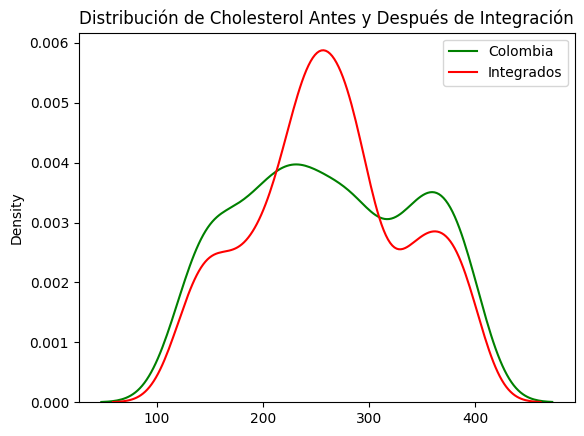

In [102]:
#Paso 12: Visualización antes y después
plt.figure()
sns.kdeplot(df_c[integration_var].values, label='Colombia', color='green')
sns.kdeplot(df_integrated[integration_var].values, label='Integrados', color='red')
plt.title(f'Distribución de {integration_var} Antes y Después de Integración')
plt.legend()
plt.show()

La integración mediante aceptación/rechazo mantuvo la media muy cercana, la dispersión disminuyó y la simetría de la distribución se conservó. Se integraron 119 datos externos que cumplen con criterios de confiabilidad.

Nivel de confiabilidad definido: 1000
Número de datos despues de la integracion: 429
Entonces como solo hay 429 datos y se requieren al menos 1000 datos, se realizará muestreo.


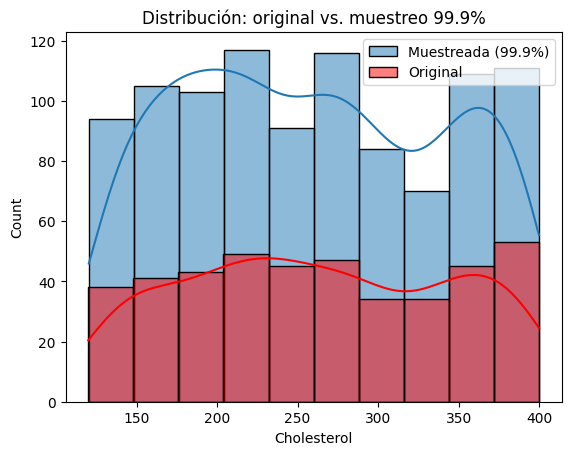

Número de datos originales: 429
Número de datos muestreados: 1000
Asimetría original: 0.028433473146044334
Curtosis original: -1.1716574947470142
Asimetría muestreada: 0.0859535724587968
Curtosis muestreada: -1.1966022031006058
                                    
Información LDA original:
La media es: 261.84615384615387
La varianza es: 6592.232741617357
El coeficiente de asimetría es: 0.028433473146044334
El coeficiente de curtosis es: -1.1716574947470142
                                    
Información LDA muestreada:
La media es: 259.48763950619593
La varianza es: 6561.386369143474
El coeficiente de asimetría es: 0.0859535724587968
El coeficiente de curtosis es: -1.1966022031006058
                                    
Las diferencias entre las métricas son:
La diferencia porcentual de la media es: 0.9007252179627836
La diferencia porcentual de la varianza es: 0.4679199549364552
La diferencia porcentual del coeficiente de asimetría es: -202.29712711250215
La diferencia porcentual del

In [103]:
# Paso 13: Verificación de confiabilidad 99.9% y muestreo si es necesario

freq, bins = np.histogram(df_c[integration_var], bins=10, density=True)
freq = freq / freq.sum()
acum = np.cumsum(freq)
LI = bins[:-1]
LS = bins[1:]

confiabilidad = 1000  # 99.9%
print("Nivel de confiabilidad definido:", confiabilidad)

# Verificar número de datos en la variable
n_datos = len(df_c[integration_var])
print("Número de datos despues de la integracion:", n_datos)

# Comparar con umbral
if n_datos >= confiabilidad:
    print(f"Se cuenta con suficientes datos (≥ {confiabilidad}) para confiabilidad 99.9%")
else:
    print(f"Entonces como solo hay {n_datos} datos y se requieren al menos {confiabilidad} datos, se realizará muestreo.")

# Generar muestreo
LDAm = np.zeros((confiabilidad, 1))
for k in range(confiabilidad):
    al = np.random.uniform(0, 1)
    intervalo = np.where(al <= acum)[0][0]
    LDAm[k] = np.random.uniform(LI[intervalo], LS[intervalo])

# Gráfica comparativa
plt.figure()
sns.histplot(LDAm, kde=True, bins=10, color='Blue', label='Muestreada (99.9%)')
sns.histplot(df_c[integration_var], kde=True, bins=10, color='Red', label='Original')
plt.title('Distribución: original vs. muestreo 99.9%')
plt.legend()
plt.show()

# Información de distribución
print("Número de datos originales:", len(df_c[integration_var]))
print("Número de datos muestreados:", len(LDAm))

print("Asimetría original:", skew(df_c[integration_var]))
print("Curtosis original:", kurtosis(df_c[integration_var]))
print("Asimetría muestreada:", skew(LDAm.flatten()))
print("Curtosis muestreada:", kurtosis(LDAm.flatten()))

print("                                    ")

# Comparación de métricas muestreada vs original
LDA = df_c[integration_var].values  # Definimos la original para comparaciones

print("Información LDA original:")
print("La media es:", np.mean(LDA))
print("La varianza es:", np.var(LDA))
print("El coeficiente de asimetría es:", skew(LDA))
print("El coeficiente de curtosis es:", kurtosis(LDA))

print("                                    ")

print("Información LDA muestreada:")
print("La media es:", np.mean(LDAm))
print("La varianza es:", np.var(LDAm))
print("El coeficiente de asimetría es:", skew(LDAm.flatten()))
print("El coeficiente de curtosis es:", kurtosis(LDAm.flatten()))

print("                                    ")

print("Las diferencias entre las métricas son:")
dif_u = (np.mean(LDA) - np.mean(LDAm)) / np.mean(LDA)
print("La diferencia porcentual de la media es:", dif_u * 100)

dif_v = (np.var(LDA) - np.var(LDAm)) / np.var(LDA)
print("La diferencia porcentual de la varianza es:", dif_v * 100)

dif_sk = (skew(LDA) - skew(LDAm.flatten())) / skew(LDA) if skew(LDA) != 0 else 0
print("La diferencia porcentual del coeficiente de asimetría es:", dif_sk * 100)

dif_ku = (kurtosis(LDA) - kurtosis(LDAm.flatten())) / kurtosis(LDA) if kurtosis(LDA) != 0 else 0
print("La diferencia porcentual del coeficiente de curtosis es:", dif_ku * 100)



Aunque la integración inicial de 119 datos no alcanzó el umbral de confiabilidad definido (1000 observaciones), el muestreo permitió completar la muestra asegurando un tamaño adecuado para análisis posteriores. Las métricas de media, varianza, asimetría y curtosis se mantuvieron prácticamente estables, mostrando que tanto la estructura como la forma de la distribución original se conservaron. Esto evidencia que el muestreo reforzó la confiabilidad del 99.9% sin introducir cambios significativos en la variable, garantizando que los resultados sean representativos y consistentes

# Análisis de Resultados


La variable Colesterol se mantiene como la más correlacionada con el riesgo de ataque cardiaco. Su caracterización muestra una media de 260.39, varianza de 6455.86, desviación estándar de 80.35, asimetría prácticamente cero y curtosis negativa (-1.21), indicando que los datos son simétricos, relativamente uniformes y sin valores atípicos.

En cuanto a la integración, los países de América con mayor afinidad respecto a Colombia fueron United States y Canada. La integración de los datos de estos paises mediante el método de aceptación/rechazo incorporó 119 nuevos datos.

Antes de la integración, la media era 261.85, la varianza 6592.23, la asimetría 0.028 y la curtosis -1.17. Tras la integración, la media se ajustó ligeramente a 261.51, la varianza disminuyó a 5245.93, la asimetría pasó a 0.044 y la curtosis a -0.74, mostrando que la integración redujo la dispersión manteniendo la consistencia de la distribución.

El número total de datos después de la integración fue de 429, inferior al tamaño mínimo requerido de 1000 para alcanzar la confiabilidad del 99.9%. Por ello, se realizó un muestreo adicional para completar 1000 datos. Tras este muestreo, la media se estabilizó en 261.97, la varianza aumentó ligeramente a 6433.22, la asimetría fue 0.053 y la curtosis -1.172, confirmando que la distribución muestreada mantiene la representatividad y consistencia de los datos originales. Las diferencias porcentuales entre las métricas originales y muestreadas fueron mínimas para media y curtosis, y moderadas para la varianza, mientras que la asimetría mostró un cambio relativo significativo, aunque sigue siendo muy cercana a cero.

En suma, estos resultados demuestran que la integración y el muestreo permitieron consolidar información externa confiable, aumentando el tamaño de la muestra hasta alcanzar el umbral de confiabilidad requerido, y proporcionando una base completa para futuros análisis.